In [1]:
import numpy as np
import geopandas as gpd


import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

from xhistogram.xarray import histogram
import dask.dataframe as dd
#import cartopy.crs as ccrs
#import cartopy.feature as cfeature

import mitequinox.utils as ut
from mitequinox.plot import *
import mitequinox.parcels as pa
from xmitgcm import llcreader

from scipy import signal
import scipy.ndimage as im
import scipy.optimize as opt

from sympy import Symbol, pi, atan, factor, lambdify

import mitequinox.plot as pl
import mitequinox.sigp as sp

from fsspec.implementations.local import LocalFileSystem

INFO: Compiled ParcelsRandom ==> /dev/shm/pbs.8588865.datarmor0/parcels-502090/libparcels_random_439f83ed-5e42-49e2-ba50-7a15d4fcf4e2.so


In [3]:
from dask.distributed import Client, LocalCluster
#cluster = LocalCluster()
#
from dask_jobqueue import PBSCluster
#
cluster = PBSCluster() #processes=7, cores=7
#
w = cluster.scale(jobs=6)
#
client = Client(cluster)

In [2]:
# Definition of the functions to compute the correlation
def correlate_E(v1, v2, dt=None, roll=False, detrend=True, ufunc=True,**kwargs):
    ''' Compute a lagged correlation between two time series
    These time series are assumed to be regularly sampled in time 
    and along the same time line.
    
    Parameters
    ----------
    
        v1, v2: ndarray, pd.Series
            Time series to correlate, the index must be time if dt is not provided
            
        dt: float, optional
            Time step
            
        detrend: boolean, optional
            Turns detrending on or off. Default is False.

    See: https://docs.scipy.org/doc/numpy/reference/generated/numpy.correlate.html
    '''
    
    assert v1.shape == v2.shape
    
    if not ufunc:
        v1 = v1.transpose((2,1,0))
        v2 = v2.transpose((2,1,0))
    
    if detrend and not roll:
        v1 = signal.detrend(v1)
        v2 = signal.detrend(v2)
        _correlate = np.correlate
        _kwargs = {'mode': 'valid'}
        N = int(v1.shape[-1]/2)
    else:
        _correlate = roll_correlate
        #if _ds1.dtype=='complex128':
        #    _kwargs = {'mode': 'full','detrend':detrend}
        #else:
        _kwargs = {'mode': 'valid','detrend':detrend}
    _kwargs.update(**kwargs)
    
    # loop over all dimensions but the last one to apply correlate
    Ni = v1.shape[:-1]
    # infer number of lags from dummy computation
    i0 = tuple(0 for i in Ni) + np.s_[:,]
    f = _correlate(v1[i0], v2[i0], **_kwargs)
    vv = np.full(Ni+f.shape, np.NaN)
    for ii in np.ndindex(Ni):
        f = _correlate(v1[ii + np.s_[:,]], v2[ii + np.s_[:,]], **_kwargs)
        Nj = f.shape
        for jj in np.ndindex(Nj):
            vv[ii + jj] = f[jj]
    
    # select only positive lags
    #vv = vv[...,:]
    
    if ufunc:
        return vv
    else:
        lags = np.arange(vv.shape[-1])*dt
        vv = vv.transpose((2,1,0))
        return lags, vv

def roll_correlate(v1, v2, Nr=None, overlap=0.5, detrend=True, **kwargs):
    ''' Correlation over temporal windows of size Nr with overlap
    '''
    i=0
    C=[]
    while i+Nr<v1.size:
        _v1 = v1[i:i+Nr]
        _v2 = v2[i:i+Nr]
        if detrend:
            _v1 = signal.detrend(_v1)
            _v2 = signal.detrend(_v2)
        C+=[np.correlate(_v1[Nr//2:], _v2, **kwargs)/(Nr/2)]
        i+=int((1-overlap)*Nr)
        
    return np.mean(np.stack(C), axis=0)
    
# quick tests
#v1 = ds.u.isel(x_u=slice(0,10), y_rho=slice(0,10)).values.transpose((1,2,0))
#v1_cor = correlate(v1, v1, dt=1/24/6)
#v1_cor = roll_correlate(v1[0,0,:], v1[0,0,:], Nr=6*24*20, overlap=0)
#v1_cor = correlate(v1, v1, roll=True, Nr=6*24*20, overlap=0)
# Wrapping function
def wrap_correlate(v1, v2, dt, lags=None, **kwargs):
    v1 = v1.chunk({'time': -1})
    v2 = v2.chunk({'time': -1})
    if lags is None:
        lags, C = correlate_E(v1.values, v2.values, dt=dt, ufunc=False, **kwargs)
        return lags, C
    else:
        #lags = np.arange(0,T//2+dt,dt)[:T//2*1/dt+1]
        if v1.dtype=='complex128':
            dtype=np.complex128
        else:
            dtype=np.float64
        C = xr.apply_ufunc(correlate_E, v1, v2,
                    dask='parallelized', output_dtypes=[dtype], #np.float64
                    input_core_dims=[['time'], ['time']],
                    output_core_dims=[['lags']],
                    dask_gufunc_kwargs={'output_sizes':{'lags': lags.size}}, kwargs=kwargs)
        return C.assign_coords(lags=lags).rename('correlation')

In [63]:
dij,dit = 2, 1
isel = dict(time=slice(0,None,dit)) #dict(face=7)
sel = dict(i=slice(0,None,dij), j=slice(0,200,dij))#, i_g=slice(3000,3100), j_g=slice(3000,3100)) # North East Hawaii
#s

In [102]:
ds = xr.open_zarr(ut.work_data_dir+'filtered_itide/SSU_filtered.zarr')
grd = xr.open_zarr(ut.work_data_dir+'rechunked/SSU_rot.zarr')[['XC','YC','Depth']]
#ut.load_grd()[['XC', 'YC', 'Depth']]#.persist()

In [87]:
ds

,Array,Chunk
Bytes,30.50 TiB,52.73 MiB
Shape,"(13, 4320, 4320, 8640)","(1, 200, 1080, 16)"
Count,617761 Tasks,617760 Chunks
Type,complex128,numpy.ndarray
,Array,Chunk
Bytes,30.50 TiB,52.73 MiB
Shape,"(13, 4320, 4320, 8640)","(1, 200, 1080, 16)"
Count,617761 Tasks,617760 Chunks
Type,complex128,numpy.ndarray


In [106]:
ds['lon'] = 0*ds.face+grd.XC
ds['lat'] = 0*ds.face+grd.YC
ds['Depth'] = 0*ds.face+grd.Depth
#ds = ds.chunk({'time':-1})#,'i':1,'j':-1

In [108]:
ds = ds.assign_coords({'lon':ds.lon,'lat':ds.lat})

In [142]:
grd = grd.assign_coords({'YC':grd.YC,'XC':grd.XC})

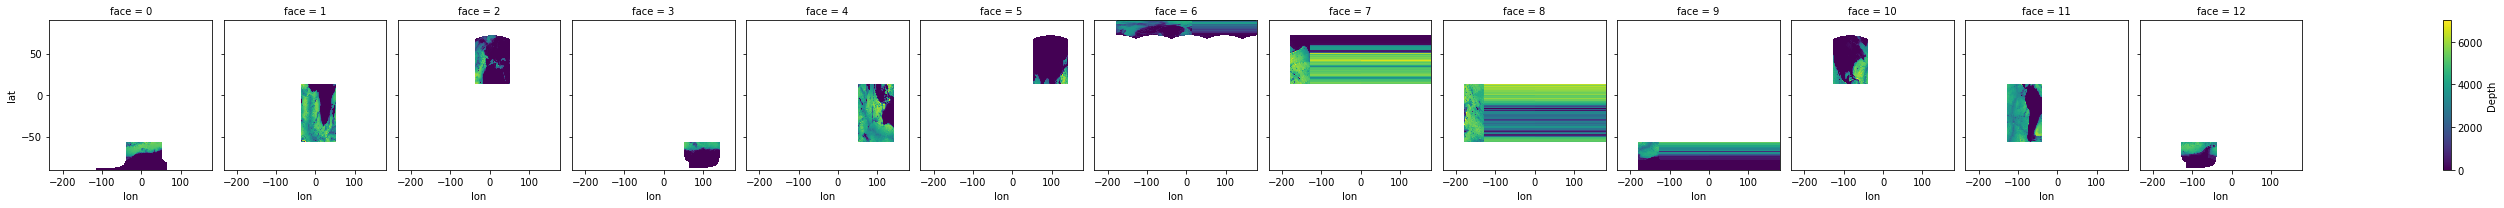

In [133]:
ds.Depth.plot(y='lat',x='lon',col='face')

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1702: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1702: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1702: UserWarning: The input coordinates to pcolormesh are interpreted as cell 

{'fig': <Figure size 1080x1080 with 1 Axes>,
 'ax': <GeoAxesSubplot:title={'center':'face = 12'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>,
 'cbar': None}

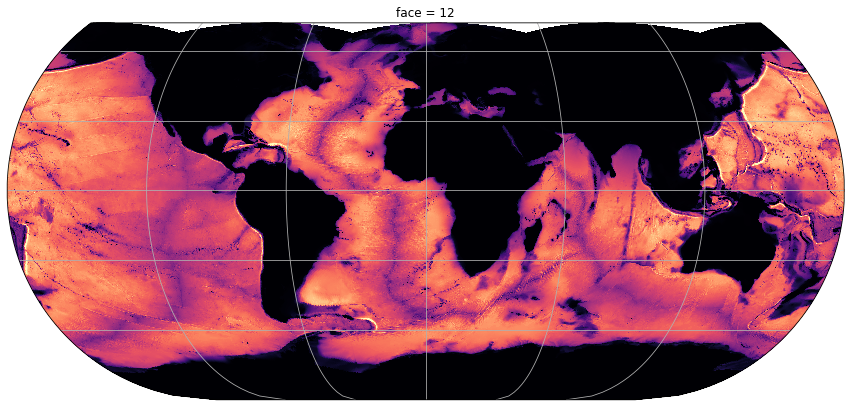

In [144]:
pl.plot_pretty(grd.Depth.isel(i=slice(0,None,4), 
                                  j=slice(0,None,4),
                                 ), 
                   infer_intervals=True,land=False
                  )

In [123]:
test = xr.combine_by_coords([ds.Depth.isel(face=i) for i in np.arange(0,13)
                ],coords=[['lon'],['lat']])

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [118]:
test

<xarray.Dataset>
Dimensions:  (i: 4320, j: 4320)
Coordinates:
    face     int64 0
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
    lon      (j, i) float64 dask.array<chunksize=(1080, 1080), meta=np.ndarray>
    lat      (j, i) float64 dask.array<chunksize=(1080, 1080), meta=np.ndarray>
Data variables:
    Depth    (j, i) float64 dask.array<chunksize=(1080, 1080), meta=np.ndarray>

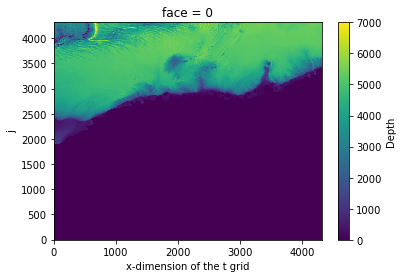

In [119]:
test.Depth.isel(i=slice(0,None,6),j=slice(0,None,6)).plot()

In [58]:
dsi = ds.isel(**isel).sel(**sel)#.persist()
#dsi = ds.sel(**sel)

In [40]:
T = 80
dt = 1/24
_u = dsi.SSU_rot_demodulated#.isel(time=slice(0,None,3))#.isel(i=slice(0,2),j=slice(0,2))

In [41]:
lags = np.arange(0,T//2+dt,dt)[:T//2*24+1][::3]


In [42]:
Crr= wrap_correlate(np.real(_u), np.real(_u),dt,lags=lags,roll=True,detrend=False, Nr=int(T/dt))#.persist()

In [43]:
Crr_mean = Crr.mean(['j']).compute()

KeyboardInterrupt: 

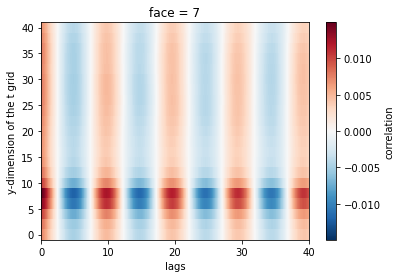

In [32]:
Crr_mean.isel(face=7).plot()

In [55]:
dsi.SSU_rot_demodulated.shape[-3]
#ds_rot = llcreader.faces_dataset_to_latlon(dsi.SSU_rot_demodulated.transpose('time','i','j','face'))

1001

In [64]:
def wrap_wrap(dsi):
    T = 80
    dt = 1/24
    _u = dsi.SSU_rot_demodulated
    lags = np.arange(0,T//2+dt,dt)[:T//2*24+1][::dit]
    Crr= wrap_correlate(np.real(_u), np.real(_u),dt,lags=lags,roll=True,detrend=False, Nr=int(T/dt))#.persist()
    return Crr

In [73]:
import os, dask
dsel = 100
#zarr_main = os.path.join(ut.root_data_dir, "filtered_itide/SSU_filtered_face4.zarr")
with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ds_out, zarr = ut.custom_distribute(dsi, 
                                        wrap_wrap,
#                                        overwrite=True,
 #                                       suffix="SSU_autocovariance.zarr",
#                                        tmp_dir=os.path.join(ut.root_data_dir, "filtered_itide"),
#                                        append=True,
                                        j=dsel
                                       )

2it [03:26, 103.34s/it]


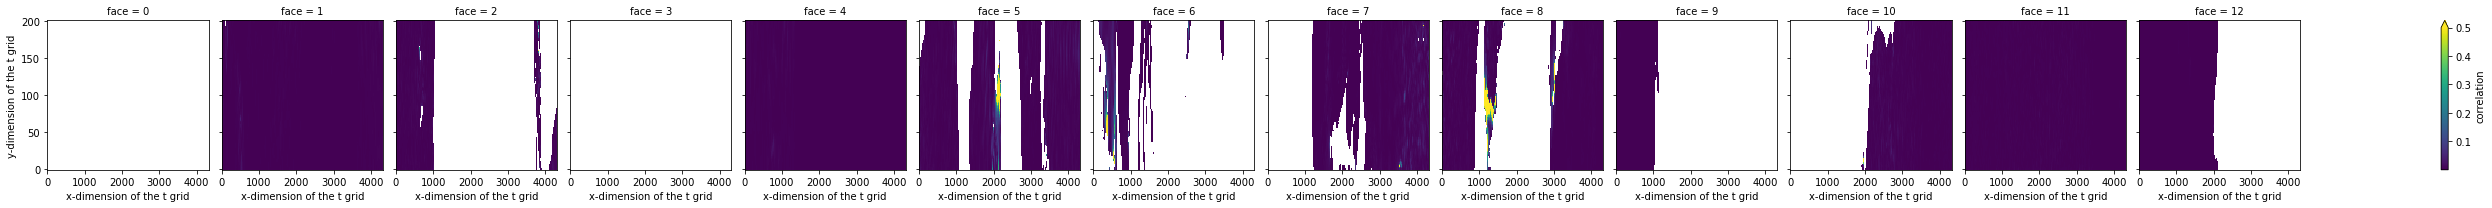

In [74]:
ds_out.isel(lags=0).plot(col='face',vmax=0.5)

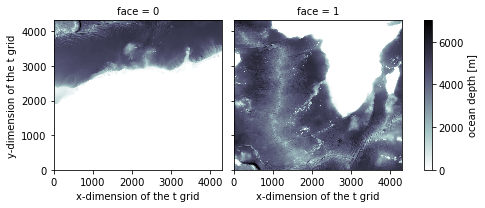

In [81]:
ds.Depth.isel(face=slice(0,2)).plot(col='face',cmap='bone_r')

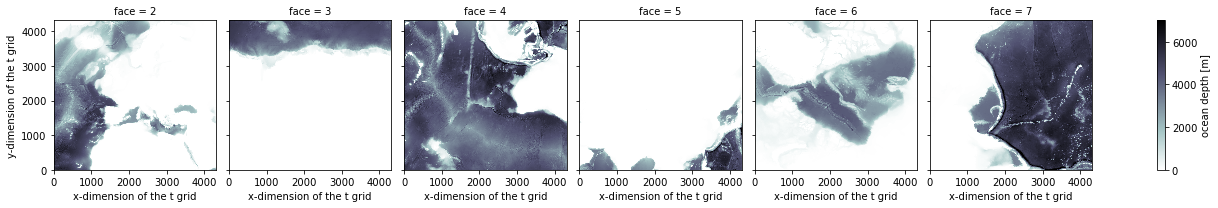

In [83]:
ds.Depth.isel(face=slice(2,8)).plot(col='face',cmap='bone_r')

In [ ]:
ds.Depth.isel(face=slice(8,14),i=slice(0,None,4),i=slice(0,None,4)).plot(col='face',cmap='bone_r')

In [22]:
Crr_mean = Crr.mean(['i','j']).compute()

In [84]:
#client.restart()

cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
